In [1]:
% matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import IOFunctions as iof
import os 
import pprint as pp
import pandas as pd
import cv2
import pickle

In [2]:
data_dir = r'C:/Users/bryn0/DHSData/'
labels_dir = r'stage1_labels.csv'
np.random.seed(seed=0)

In [ ]:
#Given image path, load, resize image and return image ndarray. 

pickle_name = 'prelim_dataset.pickle'

def getResizedImage(path,new_dim):
    #Read
    img = iof.read_data(path)
    #Shift to usual range of img pixel value (0-255)
    img_min = np.amin(img)
    img_max = np.amax(img)
    img_shifted = (img-img_min)/(img_max-img_min)*255
    #Normalize 
    img_average = np.mean(img_shifted)
    img_std = np.std(img_shifted)
    img_norm = (img_shifted-img_average)/img_std
    #Resize
    return cv2.resize(img_norm,dsize = (new_dim,new_dim))

#Create dataset from img data.  If pct < 1 then randomly chose pct of images to create data set
def getData(data_dir,labels_dir,pct = 1.,new_dim = 300,angles = [0,8,16,24,32,40,48,56]):
    #Create dictionary in the form of {'img_name': label vector}
    labels = pd.read_csv(labels_dir)
    labels = [[i,j] for i,j in zip(labels['Id'],labels['Probability'])] 
    labels_merged = iof.merge_17(labels) #Returns list of ids and corresponding list of zones
    labels_dict = {i:j for i,j in labels_merged}
    #Iterate through set of images and make a list of training data and another list of corresponding training labels
    image_names = os.listdir(data_dir)
    if pct < 1:
        image_names = np.random.choice(image_names,
                                       int(pct*len(image_names)),replace=False)
    n_samples = len(image_names)
    n_angles = len(angles)
    training_labels = np.zeros((n_samples,17))
    training_features = np.zeros((n_samples,new_dim,new_dim,n_angles))
    s = 0
    a = 0
    for image in image_names:
        img_id = image.strip().replace('.a3daps','')
        try:
            training_labels[s,:] = np.array(labels_dict[img_id])
        except(KeyError):
            print("There is no label for image{}".format(img_id))
            continue
        img_array = getResizedImage(os.path.join(data_dir,image),new_dim)
        for angle in angles:
            training_features[s,:,:,a] = img_array[:,:,angle]
            a += 1
        s += 1
        a = 0
    return training_features, training_labels
def CreateDataSet(pct):
    data_dir = r'C:/Users/bryn0/DHSData/'
    labels_dir = r'stage1_labels.csv'
    features,labels = getData(data_dir,labels_dir)
    save = {'labels':labels,'features':features}
    with open(pickle_name,"wb") as f:
        pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
        f.close()
    return
CreateDataSet(0.10)
        

There is no label for image0367394485447c1c3485359ba71f52cb
There is no label for image0749d03b6d2d1eebb6c24ecb3c36e645
There is no label for image08dc52d08482393070d8c71b11902636
There is no label for image0a83698bce92a6824dcc37c1d7fc31f5
There is no label for image0b2996d90c7250a3acb63cab6ae5bebe
There is no label for image0fadb2ac7be1a0ed6fb7cd81372c18ba
There is no label for image0fd54393dce1f55b5a4d7e30b8642158
There is no label for image104e284349ffe68378745fc8c5638eab
There is no label for image123d65c19a4d7f395b3719d47d5666b5
There is no label for image1240199d7b5d6d1c709b13381a198b75
There is no label for image12ed0db15024397106482c4983ad2d92


(1247, 300, 300, 8)
(1247, 17)


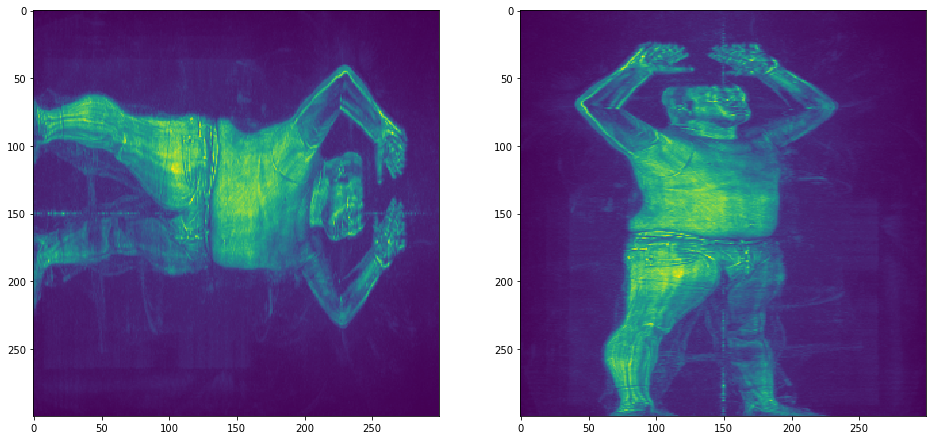

In [4]:
with open(pickle_name,"rb") as f:
    save = pickle.load(f)
    training_features = save['features']
    training_labels = save['labels']
print("Shape of feaures: {}".format(training_features.shape))
print("Shape of labels: {}".format(training_labels.shape))
#Make sure images look okay 
sample_num = 30
angle = 7
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.imshow(np.flipud(training_features[sample_num,:,:,angle].transpose()), cmap = 'viridis')
ax.imshow(training_features[sample_num,:,:,angle], cmap = 'viridis')

In [5]:
#Divide the data into train, test 
from sklearn.model_selection import train_test_split
training_features_rs = np.reshape(training_features,(training_features.shape[0],
                                             training_features.shape[1]*training_features.shape[2]*training_features.shape[3]))
X_train,X_test,y_train,y_test = train_test_split(training_features_rs,training_labels,random_state=0,train_size=0.80)


C:\Users\bryn0\AppData\Local\Continuum\Anaconda2\envs\tensorflow_3.5\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Let's train a randm forest classifier to get an estimate of the baseline performance we can achieve with a subset of the data, and the learning rate. 

In [ ]:
from sklearn.linear_model import RandomForestClassifier
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import numpy as np
import sklearn.learning_curve as curves
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer


def ModelLearning(X, y,regressor,train_sizes):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 2, test_size = 0.20, random_state = 0)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))
    
    # Calculate the training and testing scores
    sizes, train_scores, test_scores = curves.learning_curve(regressor, X, y, \
        cv = cv, train_sizes = train_sizes)

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Subplot the learning curve 
    ax = fig.add_subplot(1,1,1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Labels
    #ax.set_title('max_depth = %s'%(depth))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    #ax.set_xlim([0, X.shape[0]*0.8])
    #ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()
    
clf = RandomForestClassifier()   
train_sizes = [20,60,100,120]
ModelLearning(training_features_rs,training_labels,clf,train_sizes)

In [6]:
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print("Train Score:{}".format(clf.score(X_train,y_train)))
print("Test score:{}".format(clf.score(X_test,y_test)))

Train Score:0.8262032085561497
Test score:0.32


Now, let's work on some dimensionality reduction techniques and see if the accuracy is improved. 

